In [ ]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import networkx as nx
import torch
import gzip

import os
import random

Importing data

In [3]:
data_dir = os.path.join(os.getcwd(), 'data')
file_names = [
    "higgs-activity_time.txt.gz",
    "higgs-mention_network.edgelist.gz",
    "higgs-reply_network.edgelist.gz",
    "higgs-retweet_network.edgelist.gz",
    "higgs-social_network.edgelist.gz",
]

In [4]:
mentions: nx.classes.digraph.DiGraph = nx.read_weighted_edgelist(os.path.join(data_dir, file_names[1]), create_using=nx.DiGraph)
print(f"Loaded {file_names[1]}")
replys: nx.classes.digraph.DiGraph = nx.read_weighted_edgelist(os.path.join(data_dir, file_names[2]), create_using=nx.DiGraph)
print(f"Loaded {file_names[2]}")
retweets: nx.classes.digraph.DiGraph = nx.read_weighted_edgelist(os.path.join(data_dir, file_names[3]), create_using=nx.DiGraph)
print(f"Loaded {file_names[3]}")
# social = nx.read_edgelist(os.path.join(data_dir, file_names[4]), create_using=nx.DiGraph) # This file is around ~200MB, so I recommend only loading it by itself. It takes me ~4 minutes to load, and slows down the rest of the script when in-memory.

Loaded higgs-mention_network.edgelist.gz
Loaded higgs-reply_network.edgelist.gz
Loaded higgs-retweet_network.edgelist.gz


In [10]:
activity_times = [] # Use this how you wish.
with gzip.open(os.path.join(data_dir, file_names[0]), 'rt') as f:
    for line in f:
        activity_times.append(line.strip())
activity_times[:3]

['223789 213163 1341100972 MT',
 '223789 213163 1341100972 RE',
 '376989 50329 1341101181 RT']

Henry's Analysis Section:

In [2]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import networkx as nx
# import torch
import gzip

import os
import random

In [7]:
# Network Analysis of Higgs Twitter Networks
# 
# This notebook analyzes three directed networks related to Twitter activity around the Higgs boson discovery:
# - Mention network: User A mentioned User B
# - Reply network: User A replied to User B
# - Retweet network: User B retweeted User A

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import os
import gzip
import time
from scipy.stats import powerlaw
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

# Define the networks we're working with
networks = {
    'Mention': mentions,
    'Reply': replys,
    'Retweet': retweets
}

# Basic network information
print("Network Statistics:")
print("-" * 60)
for name, G in networks.items():
    print(f"{name} Network:")
    print(f"  Nodes: {G.number_of_nodes()}")
    print(f"  Edges: {G.number_of_edges()}")
    print(f"  Density: {nx.density(G):.6f}")
    try:
        # This may be computationally expensive for large networks
        print(f"  Average Clustering: {nx.average_clustering(G):.6f}")
    except:
        print(f"  Average Clustering: Error (likely due to network size)")
    print(f"  Strongly Connected Components: {nx.number_strongly_connected_components(G)}")
    print(f"  Weakly Connected Components: {nx.number_weakly_connected_components(G)}")
    
    # Largest component size
    largest_scc = max(nx.strongly_connected_components(G), key=len)
    print(f"  Largest SCC size: {len(largest_scc)} nodes ({len(largest_scc)/G.number_of_nodes()*100:.2f}%)")
    print("-" * 60)

Network Statistics:
------------------------------------------------------------
Mention Network:
  Nodes: 116408
  Edges: 150818
  Density: 0.000011
  Average Clustering: 0.050779
  Strongly Connected Components: 110704
  Weakly Connected Components: 10503
  Largest SCC size: 1801 nodes (1.55%)
------------------------------------------------------------
Reply Network:
  Nodes: 38918
  Edges: 32523
  Density: 0.000021
  Average Clustering: 0.003599
  Strongly Connected Components: 36132
  Weakly Connected Components: 10641
  Largest SCC size: 322 nodes (0.83%)
------------------------------------------------------------
Retweet Network:
  Nodes: 256491
  Edges: 328132
  Density: 0.000005
  Average Clustering: 0.008340
  Strongly Connected Components: 255002
  Weakly Connected Components: 13199
  Largest SCC size: 984 nodes (0.38%)
------------------------------------------------------------


Mention Network - In-degree power law exponent: 0.213
Reply Network - In-degree power law exponent: 0.271
Retweet Network - In-degree power law exponent: 0.230


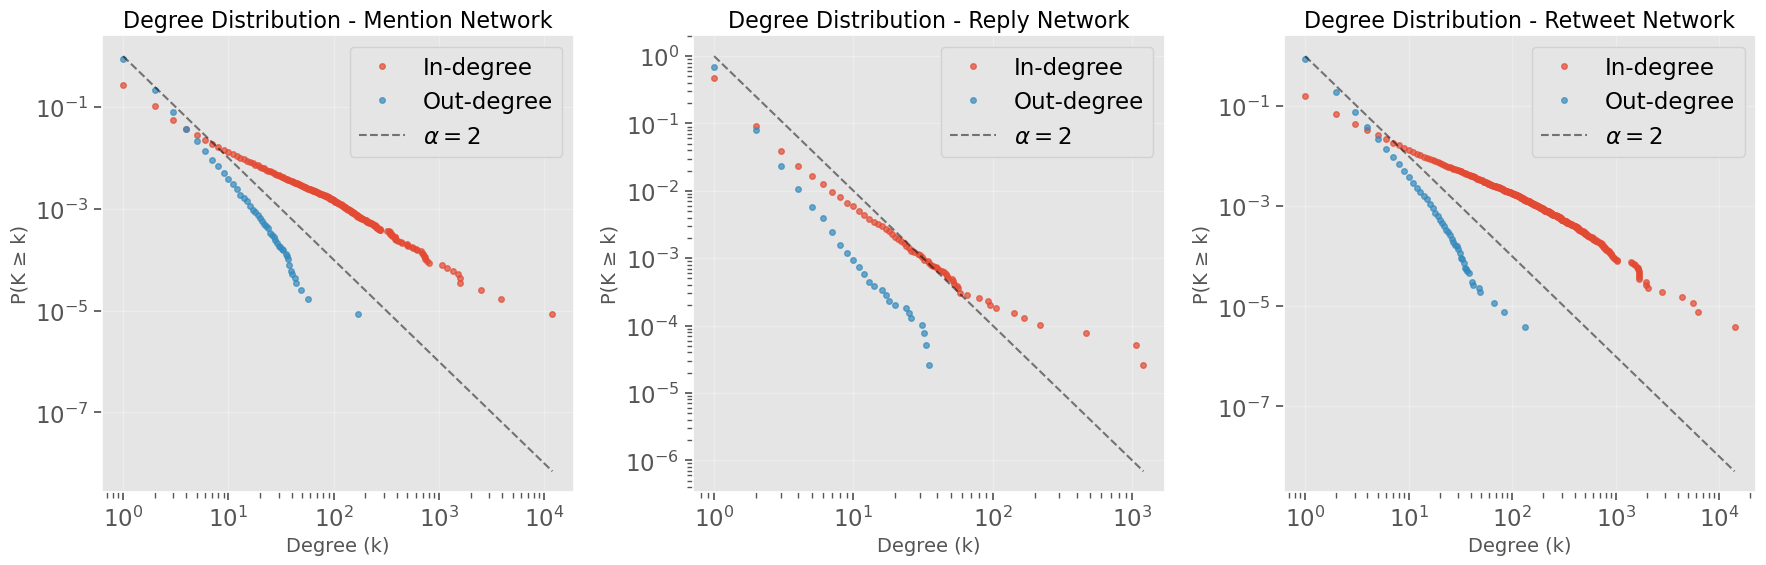

,network,avg_in_degree,max_in_degree,avg_out_degree,max_out_degree
0,Mention,1.295598,11953,1.295598,169
1,Reply,0.835680,1206,0.835680,35
2,Retweet,1.279312,14060,1.279312,134


In [8]:
# Function to compute and plot degree distributions
def analyze_degree_distribution(G, network_name, ax=None):
    """Analyze and plot the in-degree and out-degree distributions."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Get in and out degrees
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())
    
    # Count frequency of each degree
    in_degree_counts = Counter(in_degrees.values())
    out_degree_counts = Counter(out_degrees.values())
    
    # Convert to arrays for plotting
    in_x = np.array(list(in_degree_counts.keys()))
    in_y = np.array([in_degree_counts[k] for k in in_x])
    out_x = np.array(list(out_degree_counts.keys()))
    out_y = np.array([out_degree_counts[k] for k in out_x])
    
    # Create CCDF (Complementary Cumulative Distribution Function)
    in_ccdf = np.array([sum(in_y[in_x >= k]) for k in in_x]) / sum(in_y)
    out_ccdf = np.array([sum(out_y[out_x >= k]) for k in out_x]) / sum(out_y)
    
    # Plot on log-log scale
    ax.loglog(in_x, in_ccdf, 'o', markersize=4, alpha=0.7, label='In-degree')
    ax.loglog(out_x, out_ccdf, 'o', markersize=4, alpha=0.7, label='Out-degree')
    
    # Add reference power law line
    k_min = 1
    k_max = max(max(in_x), max(out_x))
    reference_x = np.logspace(np.log10(k_min), np.log10(k_max), 100)
    reference_y = reference_x**(-2)  # Power law with exponent -2
    ax.loglog(reference_x, reference_y / reference_y[0], 'k--', alpha=0.5, label=r'$\alpha = 2$')
    
    ax.set_xlabel('Degree (k)')
    ax.set_ylabel('P(K ≥ k)')
    ax.set_title(f'Degree Distribution - {network_name} Network')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Calculate power law fit for in-degree
    if len(in_x) > 5:
        try:
            # Filter out zeros for log-log fit
            mask = (in_x > 0) & (in_ccdf > 0)
            params = powerlaw.fit(in_x[mask], floc=0)
            alpha_in = params[0]
            print(f"{network_name} Network - In-degree power law exponent: {alpha_in:.3f}")
        except:
            print(f"{network_name} Network - In-degree power law fit failed")
    
    # Return statistics
    return {
        'network': network_name,
        'avg_in_degree': np.mean(list(in_degrees.values())),
        'max_in_degree': max(in_degrees.values()),
        'avg_out_degree': np.mean(list(out_degrees.values())),
        'max_out_degree': max(out_degrees.values())
    }

# Analyze degree distributions for all networks
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
degree_stats = []

for i, (name, G) in enumerate(networks.items()):
    stats = analyze_degree_distribution(G, name, axes[i])
    degree_stats.append(stats)

plt.tight_layout()
plt.show()

# Create a DataFrame with degree statistics
degree_stats_df = pd.DataFrame(degree_stats)
display(degree_stats_df)

Computing pagerank centrality for Mention Network...
  Time taken: 1.07 seconds
  Top 10 nodes by pagerank centrality:
    1. Node 88: 0.068329
    2. Node 13813: 0.045461
    3. Node 3998: 0.023757
    4. Node 59195: 0.013264
    5. Node 677: 0.012689
    6. Node 64911: 0.008330
    7. Node 2417: 0.008329
    8. Node 7533: 0.008064
    9. Node 13808: 0.007784
    10. Node 3369: 0.007148
Computing pagerank centrality for Reply Network...
  Time taken: 0.10 seconds
  Top 10 nodes by pagerank centrality:
    1. Node 677: 0.023338
    2. Node 88: 0.010048
    3. Node 220: 0.004312
    4. Node 10867: 0.003277
    5. Node 207364: 0.003277
    6. Node 152385: 0.003277
    7. Node 237807: 0.003277
    8. Node 118091: 0.003277
    9. Node 225859: 0.003277
    10. Node 201222: 0.003277
Computing pagerank centrality for Retweet Network...
  Time taken: 1.35 seconds
  Top 10 nodes by pagerank centrality:
    1. Node 88: 0.028944
    2. Node 2342: 0.011784
    3. Node 64911: 0.008695
    4. Node 1

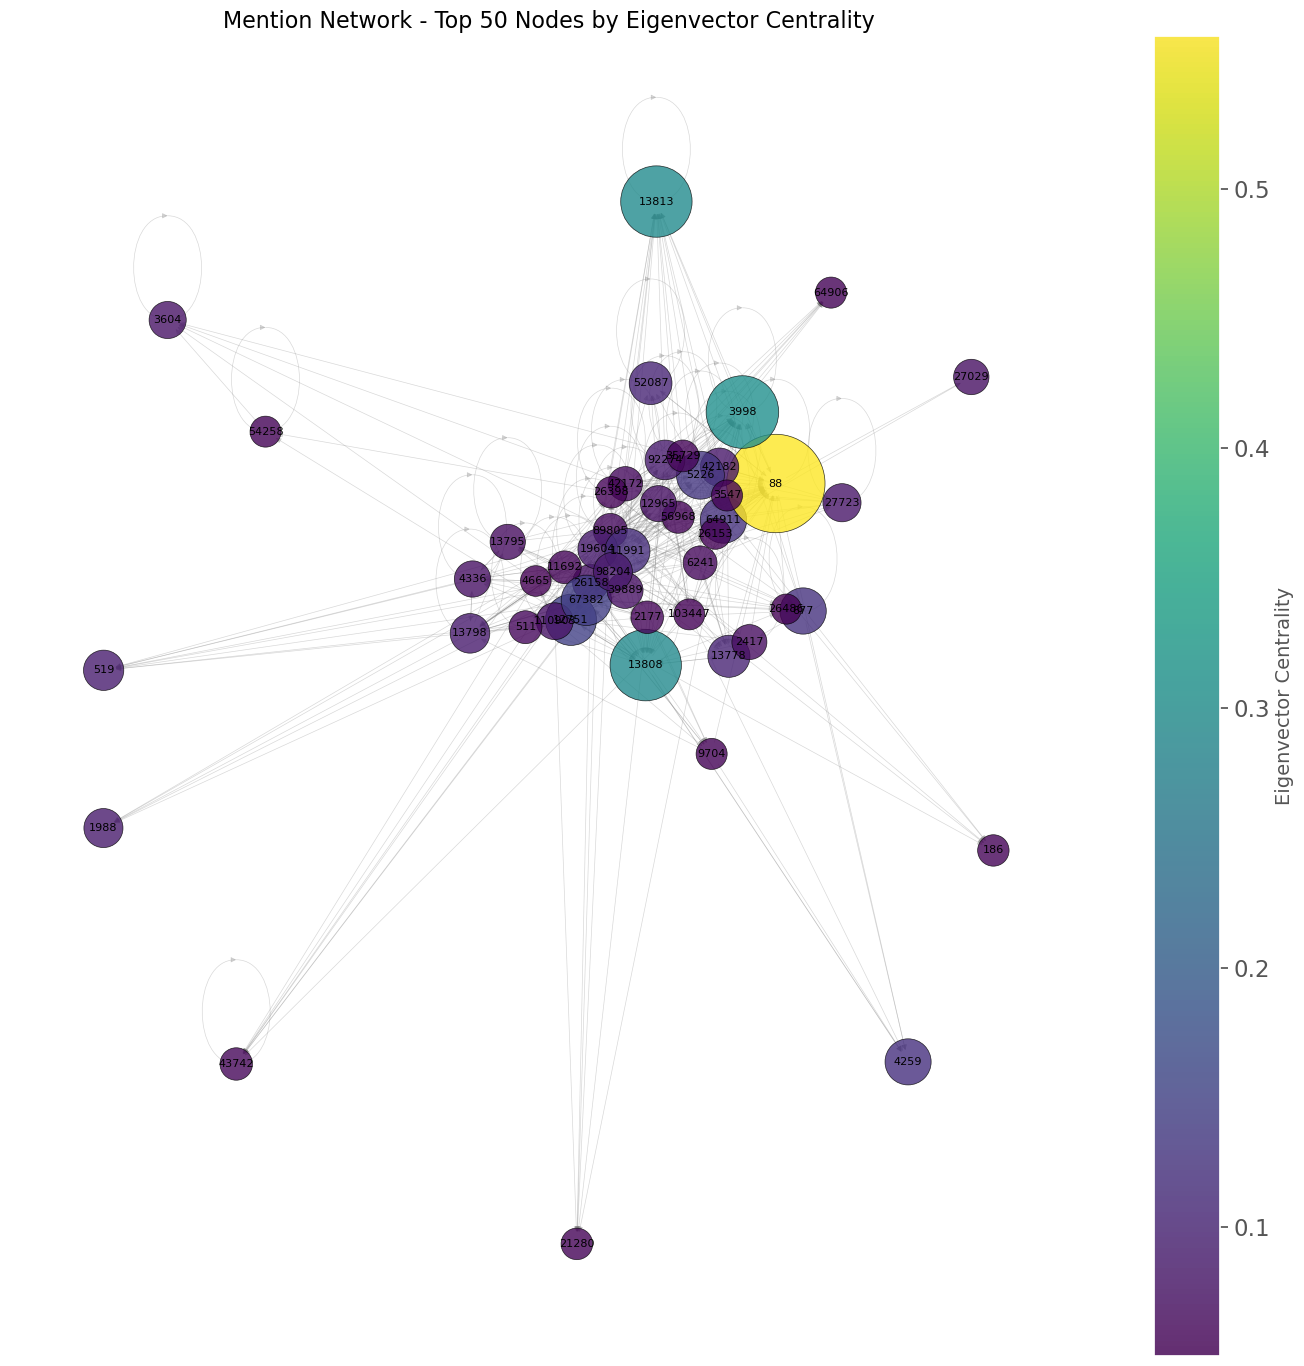

Visualizing Reply Network (subset of 75 top nodes by eigenvector centrality)...
  Subgraph has 75 nodes and 138 edges
  Computing layout...


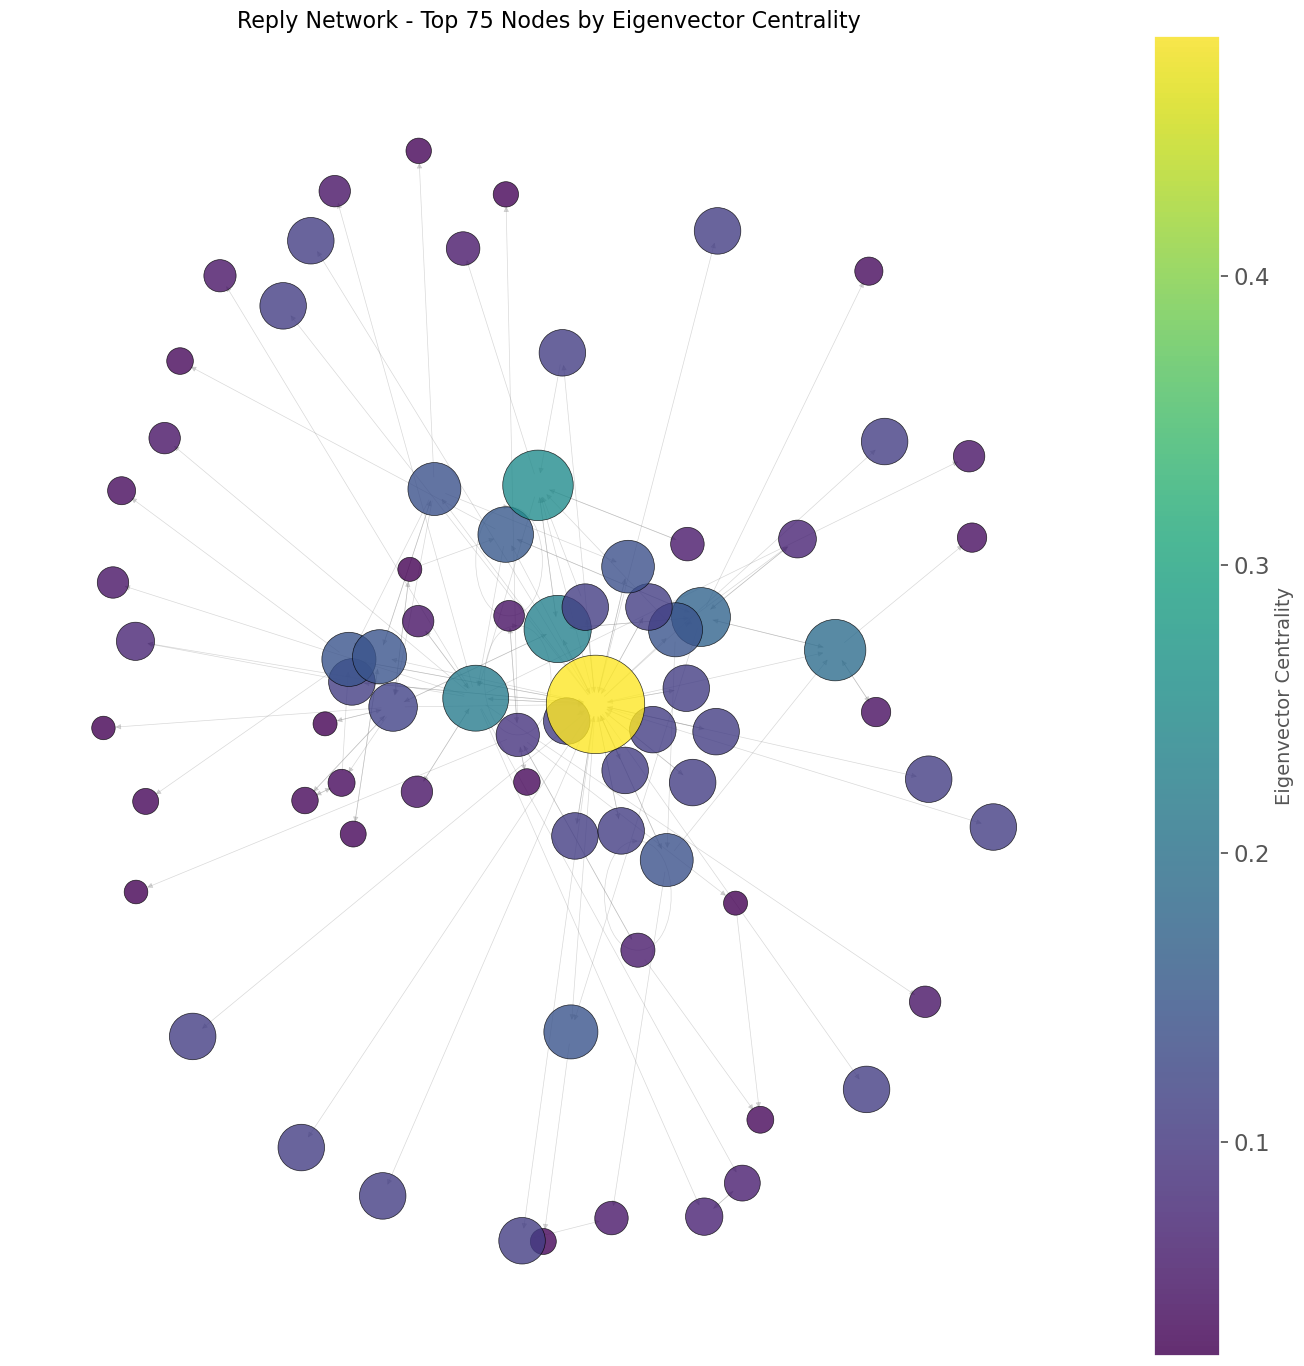

Visualizing Retweet Network (subset of 50 top nodes by eigenvector centrality)...
  Subgraph has 50 nodes and 255 edges
  Computing layout...


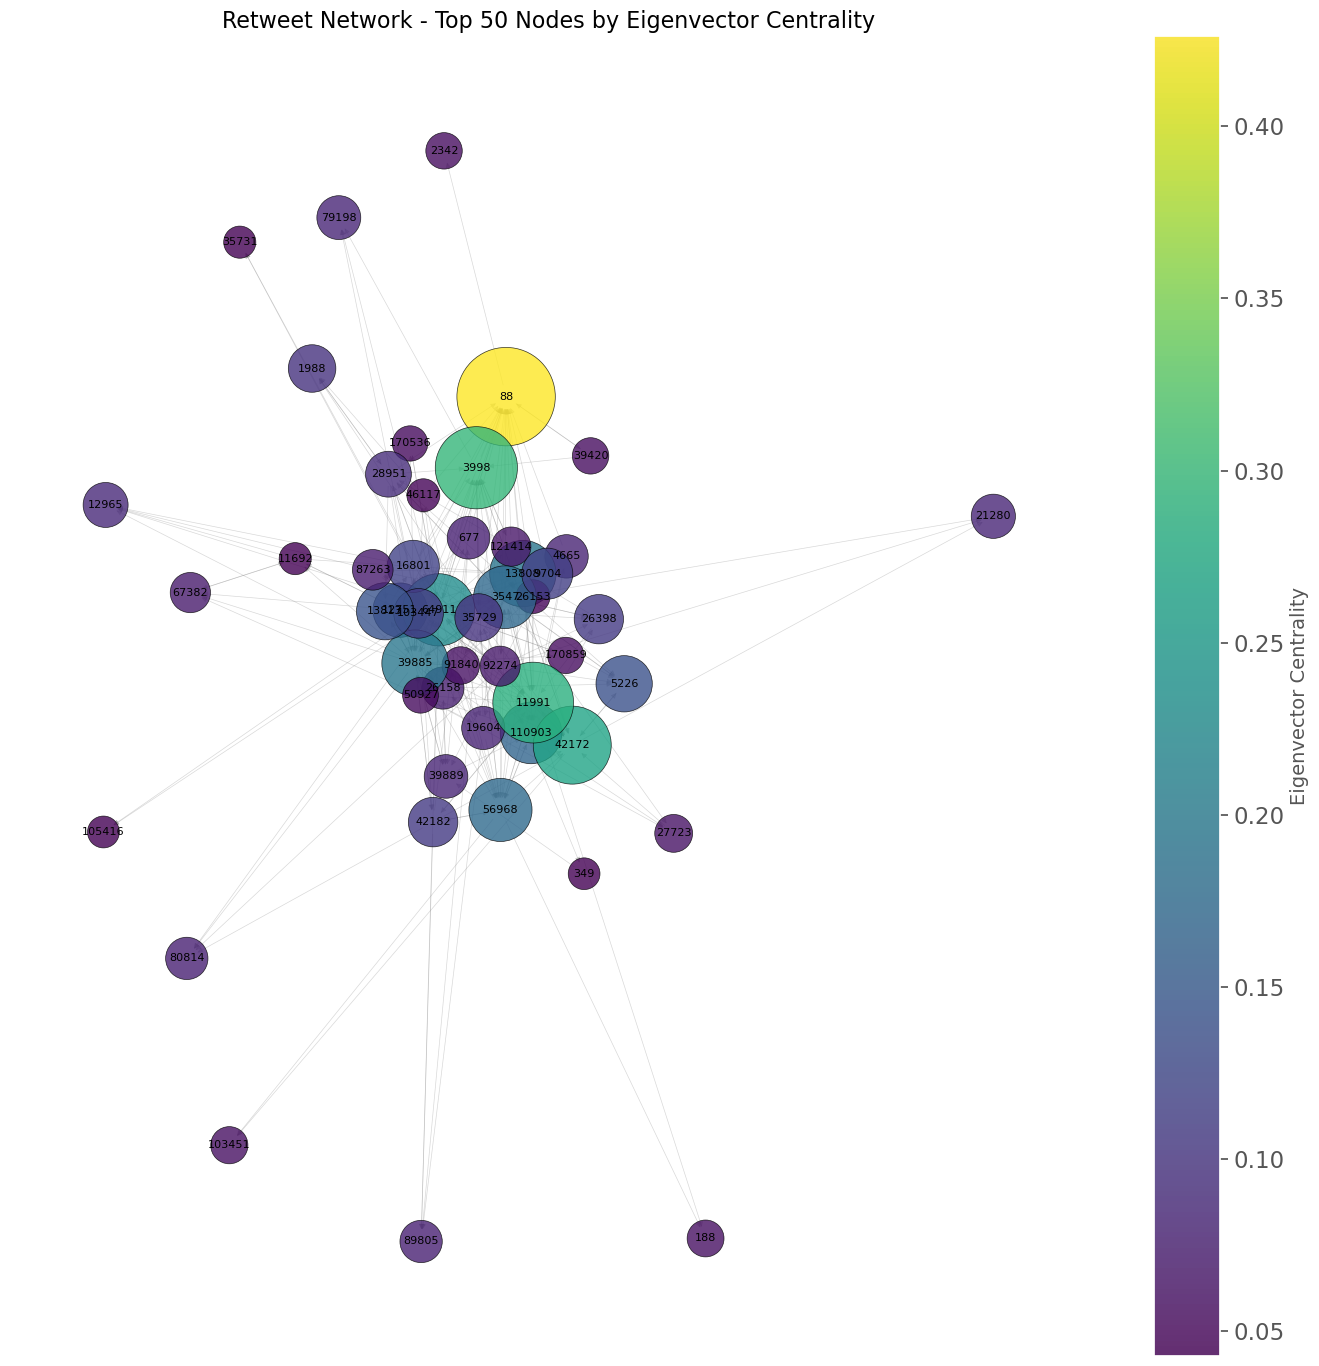

Computing betweenness centrality for Mention Network...
  Using provided sample of 500 nodes
  Time taken: 119.54 seconds
  Top 10 nodes by betweenness centrality:
    1. Node 88: 821.616611
    2. Node 64911: 796.745507
    3. Node 89805: 773.934737
    4. Node 13808: 731.380647
    5. Node 12751: 564.817729
    6. Node 67382: 485.316865
    7. Node 110903: 454.256058
    8. Node 133434: 453.000000
    9. Node 93313: 453.000000
    10. Node 6695: 453.000000
Computing betweenness centrality for Reply Network...
  Using provided sample of 500 nodes
  Time taken: 41.68 seconds
  Top 10 nodes by betweenness centrality:
    1. Node 13808: 248.800000
    2. Node 677: 213.000000
    3. Node 42177: 176.000000
    4. Node 52908: 176.000000
    5. Node 36436: 176.000000
    6. Node 52882: 176.000000
    7. Node 201222: 176.000000
    8. Node 67382: 170.466667
    9. Node 35376: 133.166667
    10. Node 6940: 129.416667
Computing betweenness centrality for Retweet Network...
  Using provided samp

In [9]:

# Function to compute and analyze centrality measures
def analyze_centrality(G, network_name, measure='pagerank', top_n=10, sample_nodes=None):
    """Compute centrality measures and return top nodes."""
    print(f"Computing {measure} centrality for {network_name} Network...")
    start_time = time.time()
    
    # For large networks, use sampling for betweenness
    if measure == 'betweenness' and G.number_of_nodes() > 10000:
        if sample_nodes is None:
            # Default to 1000 nodes or 10% of nodes, whichever is smaller
            k = min(1000, int(G.number_of_nodes() * 0.1))
            print(f"  Using approximate betweenness with k={k} nodes")
            centrality = nx.approximation.betweenness_centrality(G, k=k)
        else:
            # Use provided sample
            print(f"  Using provided sample of {len(sample_nodes)} nodes")
            centrality = nx.betweenness_centrality_subset(G, 
                                                          sources=sample_nodes,
                                                          targets=sample_nodes)
    elif measure == 'pagerank':
        centrality = nx.pagerank(G, alpha=0.85)
    elif measure == 'eigenvector':
        try:
            centrality = nx.eigenvector_centrality(G, max_iter=100)
        except nx.PowerIterationFailedConvergence:
            print(f"  Eigenvector centrality failed to converge. Using power iteration method.")
            centrality = nx.eigenvector_centrality_numpy(G)
    else:
        print(f"  Unsupported centrality measure: {measure}")
        return None
    
    # Time taken
    end_time = time.time()
    print(f"  Time taken: {end_time - start_time:.2f} seconds")
    
    # Sort nodes by centrality
    sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    
    # Get top N nodes
    top_nodes = sorted_nodes[:top_n]
    print(f"  Top {top_n} nodes by {measure} centrality:")
    for i, (node, value) in enumerate(top_nodes, 1):
        print(f"    {i}. Node {node}: {value:.6f}")
    
    # Distribution plot removed as requested
    
    return centrality

# For computational efficiency, let's sample nodes for betweenness centrality
def get_node_sample(G, n=1000):
    """Get a sample of nodes for centrality calculations."""
    if G.number_of_nodes() <= n:
        return list(G.nodes())
    else:
        return np.random.choice(list(G.nodes()), size=n, replace=False)

# Analyze PageRank for all networks
pagerank_results = {}
for name, G in networks.items():
    pagerank_results[name] = analyze_centrality(G, name, measure='pagerank')

# Analyze Eigenvector Centrality for all networks
eigenvector_results = {}
for name, G in networks.items():
    eigenvector_results[name] = analyze_centrality(G, name, measure='eigenvector')
    
# Function to visualize network with eigenvector centrality
def visualize_network(G, network_name, centrality_dict, top_n=100):
    """
    Visualize network highlighting nodes with high eigenvector centrality.
    
    Parameters:
    G (networkx.Graph): The network to visualize
    network_name (str): Name of the network
    centrality_dict (dict): Dictionary mapping node IDs to centrality values
    top_n (int): Number of top nodes to include in visualization
    """
    print(f"Visualizing {network_name} Network (subset of {top_n} top nodes by eigenvector centrality)...")
    
    # Get top nodes by centrality
    top_nodes = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_node_ids = [node for node, _ in top_nodes]
    
    # Create a subgraph with only the top nodes and their connections
    subgraph = G.subgraph(top_node_ids)
    print(f"  Subgraph has {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges")
    
    # If there are too few edges, add some more connected nodes
    if subgraph.number_of_edges() < top_n:
        # Find neighbors of top nodes and add them
        neighbors = set()
        for node in top_node_ids:
            neighbors.update(G.successors(node))
            neighbors.update(G.predecessors(node))
        
        # Limit additional nodes
        additional_nodes = list(neighbors - set(top_node_ids))[:top_n]
        expanded_nodes = top_node_ids + additional_nodes
        subgraph = G.subgraph(expanded_nodes)
        print(f"  Expanded subgraph has {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges")
    
    # Use an appropriate layout algorithm
    print("  Computing layout...")
    if subgraph.number_of_nodes() < 500:
        pos = nx.spring_layout(subgraph, seed=42, k=0.3, iterations=50)
    else:
        # For larger graphs, use faster but less optimal layout
        pos = nx.kamada_kawai_layout(subgraph)
    
    # Prepare node colors based on centrality
    node_centrality = {node: centrality_dict.get(node, 0) for node in subgraph.nodes()}
    vmin = min(node_centrality.values())
    vmax = max(node_centrality.values())
    norm = Normalize(vmin=vmin, vmax=vmax)
    
    # Plot the graph
    plt.figure(figsize=(14, 14))
    
    # Draw the nodes
    nodes = nx.draw_networkx_nodes(
        subgraph, pos,
        node_size=[5000 * (centrality_dict.get(node, 0) / vmax) + 20 for node in subgraph.nodes()],
        node_color=list(node_centrality.values()),
        cmap=plt.cm.viridis,
        alpha=0.8,
        linewidths=0.5,
        edgecolors='k'
    )
    
    # Draw the edges with transparency
    nx.draw_networkx_edges(
        subgraph, pos,
        width=0.5,
        alpha=0.3,
        arrows=True,
        arrowsize=8,
        edge_color='grey'
    )
    
    # Add a colorbar
    plt.colorbar(nodes, label='Eigenvector Centrality')
    
    # Don't plot node labels if there are too many nodes
    if subgraph.number_of_nodes() <= 50:
        nx.draw_networkx_labels(
            subgraph, pos,
            font_size=8,
            font_color='black',
            font_family='sans-serif'
        )
    
    plt.title(f'{network_name} Network - Top {top_n} Nodes by Eigenvector Centrality')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize each network
for name, G in networks.items():
    # For very large networks, visualize fewer nodes
    if G.number_of_nodes() > 100000:
        top_n = 50
    elif G.number_of_nodes() > 10000:
        top_n = 75
    else:
        top_n = 100
        
    visualize_network(G, name, eigenvector_results[name], top_n=top_n)

# Analyze Betweenness Centrality (with sampling for large networks)
betweenness_results = {}
for name, G in networks.items():
    # Use a smaller sample for very large networks
    sample_size = min(500, max(100, int(G.number_of_nodes() * 0.05)))
    sample = get_node_sample(G, sample_size)
    betweenness_results[name] = analyze_centrality(G, name, measure='betweenness', sample_nodes=sample)


In [ ]:

# Network comparison summary
def network_comparison_summary():
    """Create a summary comparing the three networks."""
    # Collect metrics
    summary = []
    for name, G in networks.items():
        # Basic network properties
        density = nx.density(G)
        try:
            assortativity = nx.degree_assortativity_coefficient(G)
        except:
            assortativity = None
        
        # Connected components
        largest_wcc = len(max(nx.weakly_connected_components(G), key=len))
        largest_scc = len(max(nx.strongly_connected_components(G), key=len))
        wcc_ratio = largest_wcc / G.number_of_nodes()
        scc_ratio = largest_scc / G.number_of_nodes()
        
        # Degree stats
        in_degrees = dict(G.in_degree())
        out_degrees = dict(G.out_degree())
        avg_in_degree = np.mean(list(in_degrees.values()))
        avg_out_degree = np.mean(list(out_degrees.values()))
        max_in_degree = max(in_degrees.values())
        max_out_degree = max(out_degrees.values())
        
        # Centralization measures (approximate)
        top_pagerank = max(pagerank_results[name].values())
        top_eigenvector = max(eigenvector_results[name].values())
        
        summary.append({
            'Network': name,
            'Nodes': G.number_of_nodes(),
            'Edges': G.number_of_edges(),
            'Density': density,
            'Assortativity': assortativity,
            'Largest WCC %': wcc_ratio * 100,
            'Largest SCC %': scc_ratio * 100,
            'Avg In-Degree': avg_in_degree,
            'Avg Out-Degree': avg_out_degree,
            'Max In-Degree': max_in_degree,
            'Max Out-Degree': max_out_degree,
            'Top PageRank': top_pagerank,
            'Top Eigenvector': top_eigenvector,
        })
    
    # Create DataFrame
    summary_df = pd.DataFrame(summary)
    display(summary_df)
    
    # Visualize comparative metrics
    metrics_to_plot = ['Density', 'Largest WCC %', 'Largest SCC %', 'Avg In-Degree', 'Avg Out-Degree']
    
    plt.figure(figsize=(14, 10))
    summary_df.set_index('Network')[metrics_to_plot].plot(kind='bar', subplots=True, 
                                                        layout=(3, 2), figsize=(14, 10), 
                                                        legend=False, sharex=False)
    plt.tight_layout()
    plt.show()
    
    return summary_df

# Generate network comparison summary
network_summary = network_comparison_summary()

# Conclusion
print("Network Analysis Conclusions:")
print("-" * 60)
print("1. Structure Comparison:")
for name, G in networks.items():
    print(f"   - {name} Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges, " 
          f"density: {nx.density(G):.6f}")

print("\n2. Degree Distribution:")
for stats in degree_stats:
    print(f"   - {stats['network']} Network: Avg in-degree: {stats['avg_in_degree']:.2f}, "
          f"Max in-degree: {stats['max_in_degree']}, "
          f"Avg out-degree: {stats['avg_out_degree']:.2f}, "
          f"Max out-degree: {stats['max_out_degree']}")

print("\n3. Centrality Analysis:")
for name in networks.keys():
    print(f"   - {name} Network: Calculated PageRank, Eigenvector, and Betweenness centrality measures")

print("\n4. Overall Network Characteristics:")
for name, G in networks.items():
    if nx.is_directed(G):
        print(f"   - {name} Network is directed with {nx.number_strongly_connected_components(G)} "
              f"strongly connected components")
    else:
        print(f"   - {name} Network is undirected with {nx.number_connected_components(G)} "
              f"connected components")

Ryan's Analysis Section:

In [4]:
# TODO